# CAM and Object Detection (modified)

## Authors: 
Sat Arora, sat.arora@uwaterloo.ca \
Richard Fan, r43fan@uwaterloo.ca

### Project Goal:
"CAM and object detection". First, you should implement some standard method for CAM for some (simple) classification network trained on image-level tags. You should also obtain object detection (spacial localization of the object approximate "center"). You should apply your approach to one specific object type (e.g. faces, or anything else). Training should be done on image-level tags (e.g. face, no face). You can come up with your specialized dataset, but feel free to use subsets of standard data. You can also test the ideas on real datasets where label noise is present.



## Abstract

Class Activation Maps (CAMs) is a very important tool and concept in Computer Vision. During classification, the goal of CAMs is to indicate the regions of the image that were used by a Convolutional Neural Network to lead it to classifying an image as containing a certain object.

In order to understand what the Class Activation Maps do, this report will describe in detail the motivation, ideas & concepts that guide our process to making our own CAMs. Following this, we will do some deeper analysis of what happens in certain scenarios to better understand our algorithms output.

The approach and motivation are inspired by [Learning Deep Features for Discriminative Localization](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) (Zhou, Khosla, Laperdriza, Oliva, Tarralba), a paper that was released in 2016. The appraoch is extended by testing our own NNs along with common ones (ResNet18) and analyzing impacts of more special scenarios.

## Team Contributions

Sat Arora: sat.arora@uwaterloo.ca
- INSERT HERE
- INSERT HERE
- INSERT HERE

Richard Fan: r43fan@uwaterloo.ca
- INSERT HERE
- INSERT HERE
- INSERT HERE

Fun fact: We are born on the same day.

## Motivation

As mentioned in the Abstract, the goal of CAMs

In [1]:
import torch
import torchvision.models as models
import cv2
import numpy as np
from torchvision import transforms
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a uniform size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

# Load train and test datasets
train_dataset = ImageFolder('Dataset/train', transform=transform)
test_dataset = ImageFolder('Dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
# USE GPU IF AVAILABLE
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

In [4]:
# Training loop

def train(model, optimizer, criterion, train_loader, test_loader, num_epochs=10):
    train_correct = 0
    train_total = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_total += labels.size(0)
            train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

            train_loss += loss.item() * images.size(0)

        epoch_loss = train_loss / len(train_dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_correct / train_total * 100:.2f}%')

    # Evaluation on test set
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss_total = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            test_loss_total += loss.item() * images.size(0)


    accuracy = test_correct / test_total
    test_loss = test_loss_total / len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

    return model

In [5]:

# Load and preprocess the image
# image_file = 'sat.png'
# image_file = '2 faces.png'
# image_file = 'river_hand.jpeg'
# image_file = 'image_2.jpg'
# image_file = 'tejas.jpg'
# image_file = 'shahan.jpg'
# image_file = 'osama.jpg'
# image_file = 'Human1250 copy.png'

def test(model, img):
    model.eval()
    # original_img = cv2.imread(image_file)

    if img is not None:
        print("Image loaded successfully!")
    else:
        print("Unable to load the image. Please check the file path.")

    features_blobs = []
    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())

    model._modules.get('layer4').register_forward_hook(hook_feature)

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_img = preprocess(img).unsqueeze(0).to(device)


    # Forward pass to get feature maps
    with torch.no_grad():
        feature_maps = model(input_img)

    params = list(model.parameters())
    weight = np.squeeze(params[-2].data.cpu().numpy())
    cam = weight[0].dot(features_blobs[0].reshape(-1, 7 * 7))

    cam = cam.reshape(7, 7)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0])) 

    # Apply heatmap on the original image
    heatmap = cv2.applyColorMap(255 - cam, cv2.COLORMAP_JET)

    return heatmap


Epoch [1/1], Train Loss: 0.1479, Train Accuracy: 95.04%
Test Loss: 0.0342, Test Accuracy: 98.49%
Image loaded successfully!


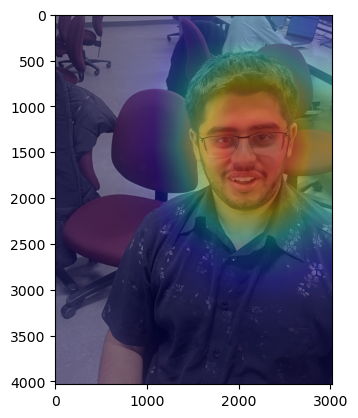

In [6]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes: face and no-face

criterion = nn.CrossEntropyLoss()

# Training model
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trained_model = train(model, optimizer, criterion, train_loader, test_loader, num_epochs=1)

# Generate heatmap
image_file = 'sat.png'
original_img = cv2.imread(image_file)
img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
heatmap = test(trained_model, img)
# print(heatmap)
output_img = heatmap * 0.3 + img.astype('float32') * 0.5
plt.imshow(output_img.astype('uint8'))

Epoch [1/2], Train Loss: 0.4578, Train Accuracy: 81.35%
Epoch [2/2], Train Loss: 0.2865, Train Accuracy: 84.80%
Test Loss: 0.3468, Test Accuracy: 85.28%
Image loaded successfully!


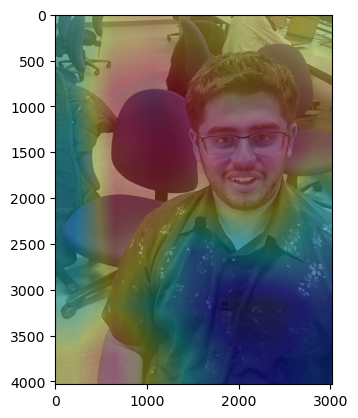

In [7]:
# Load a ResNet18 model
model = models.resnet18(pretrained=False)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes: face and no-face

criterion = nn.CrossEntropyLoss()

# Training model
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trained_model = train(model, optimizer, criterion, train_loader, test_loader, num_epochs=2)

# Generate heatmap
image_file = 'sat.png'
original_img = cv2.imread(image_file)
img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
heatmap = test(trained_model, img)
output_img = heatmap * 0.3 + original_img.astype('float32') * 0.5
plt.imshow(output_img.astype('uint8'))

In [8]:
import random
train_dataset = ImageFolder('Dataset/train', transform=transform)
test_dataset = ImageFolder('Dataset/test', transform=transform)

# Function to swap labels for misclassification
def misclassify(dataset):
    face_indices = [i for i in range(len(dataset)) if dataset[i][1] == 1]  # Assuming class 1 is for faces
    no_face_indices = [i for i in range(len(dataset)) if dataset[i][1] == 0]  # Assuming class 0 is for non-faces
    
    # Misclassify 50 face images as non-faces
    face_sampled_indices = random.sample(face_indices, 50)
    for idx in face_sampled_indices:
        dataset.targets[idx] = 0  # Change the label to non-face

    # Misclassify 50 non-face images as faces
    no_face_sampled_indices = random.sample(no_face_indices, 50)
    for idx in no_face_sampled_indices:
        dataset.targets[idx] = 1  # Change the label to face

# Apply misclassification to train and test datasets
misclassify(train_dataset)
misclassify(test_dataset)

# Create data loaders
updated_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
updated_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch [1/1], Train Loss: 0.0969, Train Accuracy: 96.08%
Test Loss: 0.1058, Test Accuracy: 96.04%
Image loaded successfully!


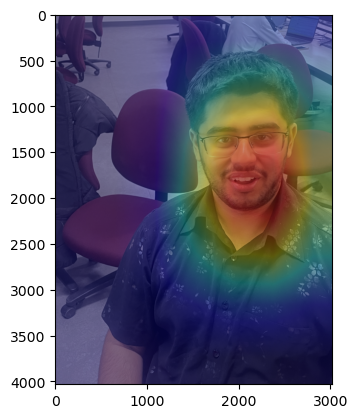

In [11]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes: face and no-face

criterion = nn.CrossEntropyLoss()

# Training model
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trained_model = train(model, optimizer, criterion, updated_train_loader, updated_test_loader, num_epochs=1)

# Generate heatmap
image_file = 'sat.png'
original_img = cv2.imread(image_file)
img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
heatmap = test(trained_model, img)
output_img = heatmap * 0.3 + img.astype('float32') * 0.5
plt.imshow(output_img.astype('uint8'))


Epoch [1/2], Train Loss: 0.4462, Train Accuracy: 81.73%
Epoch [2/2], Train Loss: 0.2580, Train Accuracy: 85.98%
Test Loss: 0.2729, Test Accuracy: 88.87%
Image loaded successfully!


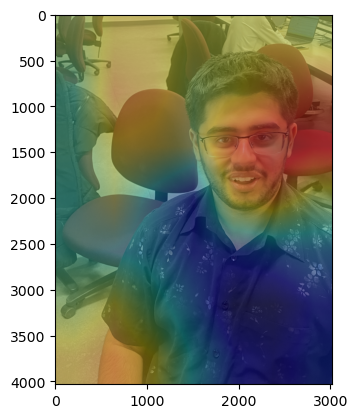

In [12]:
# Load a ResNet18 model
model = models.resnet18(pretrained=False)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes: face and no-face

criterion = nn.CrossEntropyLoss()

# Training model
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trained_model = train(model, optimizer, criterion, updated_train_loader, updated_test_loader, num_epochs=2)

# Generate heatmap
image_file = 'sat.png'
original_img = cv2.imread(image_file)
img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
heatmap = test(trained_model, img)
output_img = heatmap * 0.3 + img.astype('float32') * 0.5
plt.imshow(output_img.astype('uint8'))